# Gallery for DR6

The purpose of this notebook is to build the gallery for the sixth Legacy Survey data release, DR6.  The theme of this gallery is...the NGC catalog!

### Imports and paths

In [1]:
import os, sys
import shutil, time, warnings
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, vstack
from astropy.io import ascii
from PIL import Image, ImageDraw, ImageFont
#from astrometry.util.starutil_numpy import hmsstring2ra

In [3]:
from astrometry.util.util import Tan
from astrometry.util.fits import merge_tables
from legacypipe.survey import LegacySurveyData
from legacypipe.runbrick import run_brick

In [4]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [5]:
%matplotlib inline

### Preliminaries

Define the data release and the various output directories.

In [ ]:
PIXSCALE = 0.262

In [7]:
gallerydir = os.path.join( os.getenv('SCRATCH'), dr, 'gallery' )
#cache_dir = os.path.join('global', 'cscratch1', 'sd', 'dstn', 'dr6plus')
galleryfile = os.path.join(gallerydir, 'gallery-{}.fits'.format(dr))

In [8]:
jpgdir = os.path.join(gallerydir, 'jpg')
if not os.path.isdir(jpgdir):
    os.mkdir(jpgdir)

In [9]:
pngdir = os.path.join(gallerydir, 'png')
if not os.path.isdir(pngdir):
    os.mkdir(pngdir)

#### Read the Open NGC catalog created by Mattia Verga:
https://github.com/mattiaverga/OpenNGC

```bash
wget https://raw.githubusercontent.com/mattiaverga/OpenNGC/master/NGC.csv
```

- Name: Object name composed by catalog + number
    NGC: New General Catalogue
    IC: Index Catalogue
    
- Type: Object type
  - *: Star
  - **: Double star
  - *Ass: Association of stars
  - OCl: Open Cluster
  - GCl: Globular Cluster
  - Cl+N: Star cluster + Nebula
  - G: Galaxy
  - GPair: Galaxy Pair
  - GTrpl: Galaxy Triplet
  - GGroup: Group of galaxies
  - PN: Planetary Nebula
  - HII: HII Ionized region
  - DrkN: Dark Nebula
  - EmN: Emission Nebula
  - Neb: Nebula
  - RfN: Reflection Nebula
  - SNR: Supernova remnant
  - Nova: Nova star
  - NonEx: Nonexistent object
    
- RA: Right Ascension in J2000 Epoch (HH:MM:SS.SS)

- Dec: Declination in J2000 Epoch (+/-DD:MM:SS.SS)

- Const: Constellation where the object is located

- MajAx: Major axis, expressed in arcmin

- MinAx: Minor axis, expressed in arcmin

- PosAng: Major axis position angle (North Eastwards)

- B-Mag: Apparent total magnitude in B filter

- V-Mag: Apparent total magnitude in V filter

- J-Mag: Apparent total magnitude in J filter

- H-Mag: Apparent total magnitude in H filter

- K-Mag: Apparent total magnitude in K filter

- SurfBr (only Galaxies): Mean surface brigthness within 25 mag isophot (B-band), expressed in mag/arcsec2

- Hubble (only Galaxies): Morphological type (for galaxies)

- Cstar U-Mag (only Planetary Nebulae): Apparent magnitude of central star in U filter

- Cstar B-Mag (only Planetary Nebulae): Apparent magnitude of central star in B filter

- Cstar V-Mag (only Planetary Nebulae): Apparent magnitude of central star in V filter

- M: cross reference Messier number

- NGC: other NGC identification, if the object is listed twice in the catalog

- IC: cross reference IC number, if the object is also listed with that identification

- Cstar Names (only Planetary Nebulae): central star identifications

- Identifiers: cross reference with other catalogs

- Common names: Common names of the object if any

- NED Notes: notes about object exported from NED

- OpenNGC Notes: notes about the object data from OpenNGC catalog


In [10]:
names = ('name', 'type', 'ra_hms', 'dec_dms', 'const', 'majax', 'minax', 
         'pa', 'bmag', 'vmag', 'jmag', 'hmag', 'kmag', 'sbrightn', 'hubble', 
         'cstarumag', 'cstarbmag', 'cstarvmag', 'messier', 'ngc', 'ic', 
         'cstarnames', 'identifiers', 'commonnames', 'nednotes', 'ongcnotes')

In [11]:
NGC = ascii.read(os.path.join(gallerydir, 'NGC.csv'), delimiter=';', names=names)
NGC.write(os.path.join(gallerydir, 'NGC.fits'), overwrite=True)
NGC

name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes
str13,str6,str11,str11,str3,float64,float64,int64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,int64,str10,str14,str51,str211,str56,str80,str97
IC0002,G,00:11:00.88,-12:49:22.3,Cet,0.98,0.32,142,15.46,--,12.26,11.48,11.17,23.45,Sb,--,--,--,--,--,--,--,"2MASX J00110081-1249206,IRAS 00084-1306,MCG -02-01-031,PGC 000778",--,--,B-Mag taken from LEDA.
IC0003,G,00:12:06.09,-00:24:54.8,Psc,0.93,0.67,53,15.1,--,11.53,10.79,10.54,23.5,E,--,--,--,--,--,--,--,"2MASX J00120604-0024543,MCG +00-01-038,PGC 000836,SDSS J001206.08-002454.7,SDSS J001206.09-002454.7,SDSS J001206.09-002454.8,SDSS J001206.10-002454.8",--,--,--
IC0004,G,00:13:26.94,+17:29:11.2,Peg,1.17,0.84,12,14.2,--,11.51,10.65,10.5,23.01,Sc,--,--,--,--,--,--,--,"2MASX J00132695+1729111,IRAS 00108+1712,MCG +03-01-029,PGC 000897,UGC 00123",--,--,--
IC0005,G,00:17:34.93,-09:32:36.1,Cet,0.99,0.66,9,14.57,--,11.5,10.85,10.5,23.4,E,--,--,--,--,--,--,--,"2MASX J00173495-0932364,MCG -02-01-047,PGC 001145,SDSS J001734.93-093236.0,SDSS J001734.93-093236.1",--,--,B-Mag taken from LEDA.
IC0006,G,00:18:55.04,-03:16:33.9,Psc,1.23,1.08,146,14.5,--,11.03,10.32,10.08,23.89,E,--,--,--,--,--,--,--,"2MASX J00185505-0316339,MCG -01-01-075,PGC 001228",--,--,--
IC0007,G,00:18:53.16,+10:35:40.9,Psc,0.9,0.63,174,14.7,--,11.33,10.57,10.26,23.22,S0,--,--,--,--,--,--,--,"2MASX J00185316+1035410,PGC 001216",--,--,--
IC0008,G,00:19:02.72,-03:13:19.5,Psc,0.82,0.34,129,15.16,--,12.7,12.08,12.08,23.4,E?,--,--,--,--,--,--,--,"2MASX J00190272-0313196,MCG -01-01-076,PGC 001234",--,--,B-Mag taken from LEDA.
IC0009,G,00:19:43.98,-14:07:18.8,Cet,0.59,0.46,122,15.41,--,12.38,11.71,11.28,22.88,Sa,--,--,--,--,--,--,--,"2MASX J00194400-1407184,MCG -02-02-001,PGC 001271",--,--,B-Mag taken from LEDA.
IC0010,G,00:20:17.34,+59:18:13.6,Cas,6.76,6.03,129,13.6,9.5,7.23,6.34,6.01,24.53,IB,--,--,--,--,--,--,--,"2MASX J00201733+5918136,IRAS 00175+5902,IRAS 00177+5900,MCG +10-01-001,PGC 001305,UGC 00192",--,The 2MASX position refers to the center of the IR isophotes.,--


#### Select the desired object types.

Here we choose ...

In [12]:
majax = ma.getdata(NGC['majax']) # arcmin
objtype = np.char.strip(ma.getdata(NGC['type']))

In [13]:
keeptype = ('G', 'PN', 'OCl', 'GCl', 'Cl+N') # Cl gives us GCl, OCl, and Cl+N
#keeptype = ('G', 'GPair', 'GTrpl', 'GGroup', 'PN', 'Cl') # Cl gives us GCl, OCl, and Cl+N
keep = np.zeros(len(NGC), dtype=bool)
for otype in keeptype:
    print('Working on {}'.format(otype))
    ww = [otype == tt for tt in objtype]
    keep = np.logical_or(keep, ww)

Working on G
Working on PN
Working on OCl
Working on GCl
Working on Cl+N


#### Require "big" objects, particularly the galaxies (to cut down the sample size).

In [14]:
galtoss = (objtype == 'G') * (majax < 3)
keep = np.logical_and(keep, (majax > 0.3) * (majax < 20))
keep = np.logical_and(keep, ~galtoss)

In [15]:
nobj = np.count_nonzero(keep)
print('Keeping {} / {} objects'.format(nobj, len(NGC)))
cat = NGC[keep]
print(np.unique(ma.getdata(cat['type'])))
cat

Keeping 1676 / 13953 objects
['Cl+N' 'G' 'GCl' 'OCl' 'PN']


name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes
str13,str6,str11,str11,str3,float64,float64,int64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,int64,str10,str14,str51,str211,str56,str80,str97
IC0010,G,00:20:17.34,+59:18:13.6,Cas,6.76,6.03,129,13.6,9.5,7.23,6.34,6.01,24.53,IB,--,--,--,--,--,--,--,"2MASX J00201733+5918136,IRAS 00175+5902,IRAS 00177+5900,MCG +10-01-001,PGC 001305,UGC 00192",--,The 2MASX position refers to the center of the IR isophotes.,--
IC0166,OCl,01:52:23.82,+61:51:09.4,Cas,7.5,--,--,13.0,11.7,--,--,--,--,--,--,--,--,--,--,--,--,MWSC 0146,--,--,--
IC0239,G,02:36:27.88,+38:58:11.7,And,4.25,4.01,75,12.1,--,9.54,9.09,8.78,23.72,SABc,--,--,--,--,--,--,--,"2MASX J02362783+3858085,IRAS 02333+3845,MCG +06-06-065,PGC 009899,UGC 02080",--,--,--
IC0284,G,03:06:09.91,+42:22:18.9,Per,4.29,2.15,14,13.8,--,10.03,9.81,9.28,23.82,Sd,--,--,--,--,--,--,--,"2MASX J03060989+4222189,IRAS 03029+4211,MCG +07-07-023,PGC 011643,UGC 02531",--,--,--
IC0289,PN,03:10:19.26,+61:19:00.4,Cas,0.58,--,--,16.8,--,15.59,15.62,15.14,--,--,--,15.1,15.9,--,--,--,--,"IRAS 03062+6107,PK 138+02 1,PN G138.8+02.8",--,--,--
IC0342,G,03:46:48.50,+68:05:46.9,Cam,19.77,18.79,0,10.5,--,5.66,5.01,4.56,24.85,SABc,--,--,--,--,--,--,--,"2MASX J03464851+6805459,C5,IRAS 03419+6756,MCG +11-05-003,PGC 013826,UGC 02847",--,--,--
IC0348,Cl+N,03:44:34.19,+32:09:46.2,Per,10.0,10.0,--,--,--,--,--,--,--,--,--,--,--,--,--,1985,--,"BD +31 0643,HIP 017465,LBN 758,MWSC 0301",omi Per Cloud,--,--
IC0356,G,04:07:46.91,+69:48:44.8,Cam,4.02,3.73,90,13.3,--,7.16,6.33,6.04,23.27,Sb,--,--,--,--,--,--,--,"2MASX J04074690+6948447,IRAS 04025+6940,MCG +12-04-011,PGC 014508,UGC 02953",--,--,--
IC0361,OCl,04:18:50.70,+58:14:58.2,Cam,7.2,--,--,12.92,11.7,--,--,--,--,--,--,--,--,--,--,--,--,MWSC 0362,--,--,--


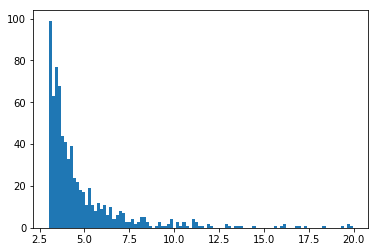

In [16]:
ww = (cat['type'] == 'G')
_ = plt.hist(cat['majax'][ww], bins=100)

#### Convert coordinates in decimal degrees.

In [17]:
coord = SkyCoord(ra=cat['ra_hms'], dec=cat['dec_dms'], unit=(u.hourangle, u.deg))
cat.add_column(Column(name='ra', unit='deg', length=nobj))
cat.add_column(Column(name='dec', unit='deg', length=nobj))
cat['ra'] = coord.ra.value
cat['dec'] = coord.dec.value

### Generate (find) the sample of objects in the DR6 footprint.

In [18]:
survey = LegacySurveyData()
survey.output_dir = gallerydir

In [19]:
def simple_wcs(obj, diam):
    """Build a simple WCS object for a single object."""
    size = np.rint(diam / PIXSCALE).astype('int') # [pixels]
    wcs = Tan(obj['ra'], obj['dec'], size/2+0.5, size/2+0.5,
                 -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                 float(size), float(size))
    return wcs

In [20]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [21]:
def build_sample_one(obj, factor=0.5, verbose=False):
    """Wrapper function to find overlapping grz CCDs for a given object.

    First generously find the nearest set of CCDs that are near the galaxy and
    then demand that there's 3-band coverage in a much smaller region centered
    on the galaxy.

    """
    print('Working on {}...'.format(obj['name'].strip()))
    diam = factor * ma.getdata(obj['majax']) * 60.0 # diameter [arcsec]
    wcs = simple_wcs(obj, diam)
    try:
        ccds = survey.ccds_touching_wcs(wcs) # , ccdrad=2*diam/3600)
    except:
        return None
    
    if ccds:
        # Is there 3-band coverage?
        if 'g' in ccds.filter and 'r' in ccds.filter and 'z' in ccds.filter:
            if verbose:
                print('For {} (type={}) found {} CCDs, RA = {:.5f}, Dec = {:.5f}, Diameter={:.4f} arcmin'.format(
                        obj['name'], obj['type'], len(ccds), obj['ra'], obj['dec'], obj['majax']))
            return obj
    return None

In [22]:
def build_sample(cat, factor=1.0):
    """Build the full sample with grz coverage in DR6."""

    sampleargs = list()
    for cc in cat:
        sampleargs.append( (cc, factor, True) ) # the False refers to verbose=False

    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))

    # Remove non-matching objects and write out the sample
    outcat = vstack(list(filter(None, result)))
    print('Found {}/{} objects in the DR6 footprint.'.format(len(outcat), len(cat)))
    
    return outcat

In [23]:
samplelogfile = os.path.join(gallerydir, 'build-sample.log')
print('Building the sample.')
print('Logging to {}'.format(samplelogfile))
t0 = time.time()
with open(samplelogfile, 'w') as log:
    with redirect_stdout(log):
        sample = build_sample(cat)
print('Found {}/{} objects in the DR6 footprint.'.format(len(sample), len(cat)))
print('Total time = {:.3f} seconds.'.format(time.time() - t0))

Building the sample.
Logging to /global/cscratch1/sd/ioannis/dr6/gallery/build-sample.log
Found 120/1676 objects in the DR6 footprint.
Total time = 4.079 seconds.


In [24]:
print('Writing {}'.format(galleryfile))
sample.write(galleryfile, overwrite=True)

Writing /global/cscratch1/sd/ioannis/dr6/gallery/gallery-dr6.fits


In [25]:
sample

name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes,ra,dec
str52,str24,str44,str44,str12,float64,float64,int64,float64,float64,float64,float64,float64,float64,str16,float64,float64,float64,int64,str40,str56,str204,str844,str224,str320,str388,float64,float64
IC0712,G,11:34:49.31,+49:04:39.7,UMa,3.02,0.89,91,14.8,--,10.84,10.17,9.89,25.42,E,--,--,--,--,--,--,--,"2MASX J11344932+4904388,MCG +08-21-063,PGC 035785,SDSS J113449.29+490439.4,SDSS J113449.29+490439.5,SDSS J113449.29+490439.7,SDSS J113449.30+490439.5",--,--,--,173.705458333,49.0776944444
IC3687,G,12:42:15.10,+38:30:12.0,CVn,3.34,3.08,0,15.5,--,--,--,--,25.04,IAB,--,--,--,--,--,--,--,"MCG +07-26-039,PGC 042656,UGC 07866",--,--,--,190.562916667,38.5033333333
IC4182,G,13:05:49.54,+37:36:17.6,CVn,6.01,5.52,0,11.86,--,--,--,--,25.09,Sm,--,--,--,--,--,--,--,"MCG +06-29-031,PGC 045314,SDSS J130548.70+373613.0,UGC 08188",--,--,--,196.456416667,37.6048888889
NGC2146,G,06:18:37.71,+78:21:25.3,Cam,5.31,4.32,123,11.38,10.59,8.23,7.42,7.06,22.76,SBab,--,--,--,--,--,--,--,"2MASX J06183771+7821252,IRAS 06106+7822,MCG +13-05-022,PGC 018797,UGC 03429",--,--,--,94.657125,78.3570277778
NGC2281,OCl,06:48:17.84,+41:04:43.9,Aur,10.8,--,--,6.05,5.4,--,--,--,--,--,--,--,--,--,--,--,--,MWSC 0989,--,--,--,102.074333333,41.0788611111
NGC2340,G,07:11:10.83,+50:10:29.1,Lyn,3.16,1.64,71,13.9,--,9.95,9.26,8.88,24.06,E,--,--,--,--,--,--,--,"2MASX J07111080+5010288,MCG +08-13-096,PGC 020338,UGC 03720",--,--,--,107.795125,50.17475
NGC2419,GCl,07:38:07.95,+38:52:47.9,Lyn,4.5,--,--,--,10.05,--,--,--,--,--,--,--,--,--,--,--,--,"2MASX J07380795+3852479,C25,MWSC 1290",--,--,--,114.533125,38.8799722222
NGC2424,G,07:40:39.29,+39:13:59.9,Lyn,3.37,0.52,82,13.9,--,10.38,9.62,9.32,23.77,Sb,--,--,--,--,--,--,--,"2MASX J07403931+3914003,IRAS 07372+3920,MCG +07-16-009,PGC 021558,SDSS J074039.28+391359.8,SDSS J074039.28+391359.9,SDSS J074039.29+391359.9,UGC 03959",--,--,--,115.163708333,39.2333055556
NGC2541,G,08:14:40.12,+49:03:42.2,Lyn,3.02,1.6,170,12.26,11.8,10.87,10.2,10.09,22.85,SABc,--,--,--,--,--,--,--,"2MASX J08144007+4903411,IRAS 08110+4912,MCG +08-15-054,PGC 023110,SDSS J081440.11+490342.1,UGC 04284",--,--,--,123.667166667,49.0617222222


In [77]:
print(np.unique(sample['type']).data)

['G' 'GCl' 'OCl' 'PN']


In [26]:
def qa_sample():
    fig, ax = plt.subplots()
    ax.scatter(cat['ra'], cat['dec'], alpha=0.5, s=10, label='Trimmed NGC Catalog')
    ax.scatter(sample['ra'], sample['dec'], s=20, label='Objects in DR6 Footprint')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='lower right')

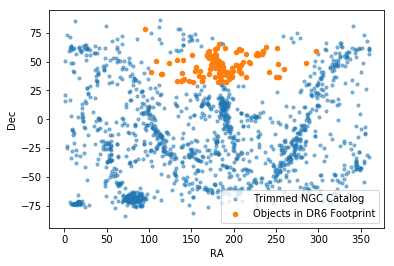

In [27]:
qa_sample()

### Generate the color mosaics for each object.

In [62]:
def custom_brickname(obj, prefix='custom-'): 
    brickname = 'custom-{:06d}{}{:05d}'.format(
        int(1000*obj['ra']), 'm' if obj['dec'] < 0 else 'p', 
        int(1000*np.abs(obj['dec'])))
    return brickname

In [94]:
def make_coadds_one(obj, factor=1.5, scale=PIXSCALE, clobber=False):
    name = ma.getdata(obj['name']).tolist()
    print(name)
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name.lower()))
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        diam = factor * ma.getdata(obj['majax']) * 60.0 # diameter [arcsec]
        #if diam >= 10:
        #    scale = 1.0
        #elif (diam >= 2) & (diam < 10):
        #    scale = 0.5
        #else:
        #    scale = PIXSCALE
        
        size = np.rint(diam / scale).astype('int') # [pixels]
        print('Generating mosaic for {} (type={}) with width={} pixels.'.format(obj['name'], obj['type'], size))
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            run_brick(None, survey, radec=(obj['ra'], obj['dec']), pixscale=scale, 
                      width=size, height=size, stages=['image_coadds'], splinesky=True,
                      early_coadds=True, pixPsf=True, hybridPsf=True, normalizePsf=True,
                      write_pickles=False, depth_cut=False, apodize=True, threads=nproc,
                      do_calibs=False, ceres=False)
            
        sys.stdout.flush()    
        brickname = custom_brickname(obj, prefix='custom-')
        _jpgfile = os.path.join(survey.output_dir, 'coadd', 'cus', brickname, 
                               'legacysurvey-{}-image.jpg'.format(brickname))
        shutil.copy(_jpgfile, jpgfile)
        shutil.rmtree(os.path.join(survey.output_dir, 'coadd'))

In [92]:
def make_coadds(sample, clobber=False):
    ww = ma.getdata(sample['messier']) != 0
    for obj in sample:
        make_coadds_one(obj, clobber=clobber)

In [95]:
make_coadds_one(sample[6], clobber=True)

NGC2419
Generating mosaic for NGC2419 (type=GCl) with width=1350 pixels.
Total Memory Available to Job:
Maximum VMEM                      (RLIMIT_AS      ) :                   -1                   -1
Maximum core file size            (RLIMIT_CORE    ) :                    0                   -1
Maximum CPU time                  (RLIMIT_CPU     ) :                   -1                   -1
Maximum file size                 (RLIMIT_FSIZE   ) :                   -1                   -1
Maximum heap size                 (RLIMIT_DATA    ) :                   -1                   -1
Maximum stack size                (RLIMIT_STACK   ) :                   -1                   -1
Maximum resident set size         (RLIMIT_RSS     ) :                   -1                   -1
Maximum number of processes       (RLIMIT_NPROC   ) :                 2048                 8192
Maximum number of open files      (RLIMIT_NOFILE  ) :                 4096                65536
Maximum lockable memory address 

Process ForkPoolWorker-17:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 106080 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-18:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-19:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 106087 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 106100 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 106119 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106134 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-22:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._

Starting process 106151 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-23:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 106168 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-24:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-25:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproces

Starting process 106185 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-26:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106202 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106221 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-27:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106236 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-28:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages

Starting process 106253 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-29:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 106272 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-30:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


TypeError: __init__() missing 1 required positional argument: 'error_callback'

Traceback (most recent call last):


RunstageStarting process 106287 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-31:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/co

Starting process 106302 Wall: -0.00 s, CPU: -0.00 s
 image_coadds


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-32:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global

 image_coaddsStarting process 106342 Wall: -0.00 s, CPU: -0.00 s
Runstage mask_junk


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-33:
Traceback (most recent call last):


Runstage mask_junkStarting process 106357 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-34:


Runstage tims


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Runstage timsStarting process 106368 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Running stage tims


Process ForkPoolWorker-35:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Running stage timsStarting process 106387 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-36:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 106404 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-37:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global

Starting process 106437 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-38:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106444 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-39:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
At

Starting process 106469 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-40:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106485 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-41:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106506 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-42:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106523 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-43:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106540 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-44:


Starting process 106543 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-45:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 106550 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-46:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 106561 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-47:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  

Starting process 106576 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-48:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106595 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-49:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = g

Starting process 106612 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-50:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 106631 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-51:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 106648 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-52:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106665 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-53:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 106682 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-54:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_by

Starting process 106697 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-55:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106716 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-56:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_by

Starting process 106731 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-57:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106750 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-58:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106767 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-59:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  

Starting process 106812 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-60:
Traceback (most recent call last):


Starting process 106815 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-61:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106822 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-62:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 106835 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-63:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-64:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    se

Starting process 106850 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 106865 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-65:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 106886 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-66:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 106903 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-67:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106920 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-68:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106937 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-69:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 106954 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-70:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 106973 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-71:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = g

Starting process 106989 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-72:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107008 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-73:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107025 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-74:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107042 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-75:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
At

Starting process 107087 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-76:


Starting process 107090 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-77:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 107097 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-78:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 107108 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-79:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-80:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent cal

Starting process 107123 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107142 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-81:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107161 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-82:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107178 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-83:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 107195 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
Process ForkPoolWorker-84:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 107210 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-85:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 107225 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-86:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages

Starting process 107242 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-87:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107263 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-88:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107280 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-89:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107305 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-90:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 107322 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-91:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError:

Starting process 107368 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-92:
Traceback (most recent call last):


Starting process 107371 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-93:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107378 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-94:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107391 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-95:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107408 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-96:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107425 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-97:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 107442 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-98:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107461 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-99:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107476 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-100:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107495 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-101:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 107511 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-102:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107528 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-103:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 107543 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-104:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107558 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-105:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107581 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-106:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 107596 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-107:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproce

Starting process 107641 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-108:


Starting process 107644 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-109:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107651 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-110:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-111:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call 

Starting process 107664 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-112:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 107681 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-113:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 107698 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-114:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 107715 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107734 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-115:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 107751 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-116:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 107766 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-117:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 107783 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-118:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", l

Starting process 107799 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-119:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107818 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-120:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107835 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-121:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 107852 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-122:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 107869 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-123:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproce

Starting process 107914 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-124:


Starting process 107917 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-125:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 107924 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-126:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 107935 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-127:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 107952 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-128:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 107969 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-129:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_b

Starting process 107986 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-130:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108005 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-131:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108022 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-132:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108039 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-133:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108056 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-134:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108073 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-135:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108090 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-136:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108109 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-137:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108135 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-138:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108152 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-139:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 108197 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-140:


Starting process 108200 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-141:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 108207 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-142:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call l

Starting process 108218 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-143:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108237 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-144:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-145:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 108254 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 108269 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-146:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 108288 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-147:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessi

Starting process 108305 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-148:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108322 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-149:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108339 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-150:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 108356 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-151:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108375 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-152:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108390 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-153:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108407 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-154:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 108424 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-155:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/c

Starting process 108469 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-156:
Traceback (most recent call last):


Starting process 108472 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-157:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 108479 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-158:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 108492 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-159:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108509 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-160:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108526 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-161:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108543 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-162:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108560 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-163:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108577 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-164:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108594 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-165:
Traceback (most recent call last):


Starting process 108611 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-166:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cor

Starting process 108626 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-167:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108645 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-168:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108662 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-169:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108679 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-170:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 108696 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-171:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", lin

Starting process 108741 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-172:
Traceback (most recent call last):


Starting process 108745 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-173:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 108752 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-174:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_b

Starting process 108763 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-175:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108782 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-176:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 108799 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-177:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 108816 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-178:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108833 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-179:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108850 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-180:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108867 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-181:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 108884 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-182:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 108901 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-183:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108918 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-184:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108935 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-185:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 108952 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-186:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 108969 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-187:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' o

Starting process 109014 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-188:


Starting process 109017 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-189:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109024 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-190:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109037 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-191:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109054 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-192:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 109071 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-193:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12

Starting process 109090 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-194:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109105 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-195:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109122 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-196:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109139 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-197:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109156 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-198:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109173 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-199:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109190 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-200:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109207 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-201:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109224 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-202:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109241 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-203:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
A

Starting process 109286 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-204:
Traceback (most recent call last):
Process ForkPoolWorker-205:


Starting process 109289 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109296 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-206:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109309 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-207:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109326 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-208:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 109343 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-209:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/globa

Starting process 109360 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-210:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-211:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 109377 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-212:


Starting process 109394 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 109411 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-213:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 109428 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-214:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 109445 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-215:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-216:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    

Starting process 109460 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-217:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 109475 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-pa

Starting process 109496 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-218:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109513 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-219:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
T

Starting process 109558 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-220:
Traceback (most recent call last):


Starting process 109561 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-221:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 109568 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-222:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 109579 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-223:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-package

Starting process 109594 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-224:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109615 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-225:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109632 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-226:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109649 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-227:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109666 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-228:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109683 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-229:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109700 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-230:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109717 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-231:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109734 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-232:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109751 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-233:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109768 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-234:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
  

Starting process 109785 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-235:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproce

Starting process 109830 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-236:


Starting process 109833 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-237:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 109840 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-238:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 109851 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-239:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 109870 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-240:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 109885 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-241:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 109900 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-242:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 109917 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-243:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 109938 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-244:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109955 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-245:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109974 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-246:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 109991 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-247:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110008 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-248:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110025 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-249:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110042 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-250:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110059 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-251:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 110104 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-252:
Traceback (most recent call last):


Starting process 110107 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-253:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 110114 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-254:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 110125 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-255:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110144 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-256:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 110161 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-257:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 110176 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-258:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110195 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-259:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110212 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-260:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110229 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-261:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110246 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-262:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110263 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-263:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110280 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-264:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110299 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-265:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110316 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-266:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110333 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-267:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
  

Starting process 110378 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-268:


Starting process 110381 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-269:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 110388 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-270:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-271:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/commo

Starting process 110399 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110418 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-272:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110435 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-273:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 110454 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-274:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110471 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-275:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110486 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-276:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110503 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-277:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 110524 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-278:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110541 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-279:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 110554 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-280:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110571 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-281:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110589 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-282:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 110610 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-283:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError

Starting process 110651 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-284:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 110654 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-285:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110661 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-286:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110674 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-287:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110691 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-288:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110710 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-289:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110725 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-290:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 110744 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-291:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 110763 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-292:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110778 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-293:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 110793 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-294:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 110811 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-295:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
T

Starting process 110836 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-296:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 110855 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-297:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 110872 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-298:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 110890 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-299:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 110936 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-300:


Starting process 110939 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-301:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110946 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-302:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 110959 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-303:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 110976 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-304:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 110995 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-305:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111010 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-306:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111027 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-307:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 111044 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-308:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111063 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-309:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111078 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-310:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111095 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-311:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111112 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-312:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111129 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-313:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
T

Starting process 111146 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-314:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 111165 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-315:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError

Starting process 111208 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-316:


Starting process 111211 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-317:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 111218 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-318:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 111229 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-319:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 111244 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-320:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111263 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-321:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111282 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-322:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111299 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-323:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111316 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-324:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111333 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-325:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111350 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-326:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 111367 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-327:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call l

Starting process 111382 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-328:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111401 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-329:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 111418 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-330:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 111433 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-331:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12

Starting process 111480 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-332:
Traceback (most recent call last):


Starting process 111483 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-333:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111490 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-334:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-335:
  File "/global/common/cori/co

Starting process 111503 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-336:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111520 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 111537 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-337:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", lin

Starting process 111552 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111571 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-339:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 111588 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-340:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111603 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-341:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111620 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-342:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 111643 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-343:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 111667 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-344:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111684 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-345:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 111701 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-346:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111729 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-347:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
  

Starting process 111772 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-348:
Traceback (most recent call last):


Starting process 111775 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-349:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111782 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-350:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111795 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-351:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 111812 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-352:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111831 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-353:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111846 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-354:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111863 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-355:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111880 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-356:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-357:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_byte

Starting process 111897 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 111912 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-358:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 111931 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-359:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
  

Starting process 111948 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 111965 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-361:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 111982 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-362:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cor

Starting process 111999 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-363:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
A

Starting process 112054 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-364:


Starting process 112057 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-365:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 112064 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-366:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 112075 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-367:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 112094 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-368:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 112111 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-369:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 112126 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-370:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112145 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-371:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112162 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-372:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112179 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-373:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 112196 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-374:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 112215 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-375:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 112232 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-376:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 112245 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-377:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 112264 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-378:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 112281 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-379:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 112326 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-380:


Starting process 112329 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-381:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 112336 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-382:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 112347 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-383:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cor

Starting process 112364 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-384:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112383 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-385:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 112400 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-386:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 112417 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-387:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-388:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "

Starting process 112432 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-389:


Starting process 112449 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-390:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 112532 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 112549 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-391:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112566 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-392:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112583 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-393:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 112600 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-394:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
T

Starting process 112617 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-395:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproce

Starting process 112662 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-396:


Starting process 112665 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-397:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 112681 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-398:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 112694 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-399:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 112709 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-400:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 112728 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-401:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 112745 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-402:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-403:
  File "/global/commo

Starting process 112762 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112779 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-404:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112796 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-405:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112813 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-406:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112830 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-407:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 112847 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-408:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112866 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-409:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112881 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-410:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 112899 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-411:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError

Starting process 112945 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-412:
Traceback (most recent call last):


Starting process 112948 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-413:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 112955 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-414:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 112966 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-415:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 112983 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-416:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113002 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-417:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 113030 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-418:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 113047 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-419:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 113064 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-420:
Traceback (most recent call last):
Process ForkPoolWorker-421:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113081 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 113096 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-422:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 113115 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-423:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113132 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-424:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113149 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-425:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113166 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-426:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 113183 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-427:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boot

Starting process 113228 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-428:
Traceback (most recent call last):


Starting process 113231 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-429:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 113238 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-430:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 113249 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-431:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-package

Starting process 113268 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-432:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113285 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-433:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 113302 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-434:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 113319 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-435:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 113336 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-436:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 113355 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-437:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113370 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-438:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113387 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-439:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 113404 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-440:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 113419 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-441:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 113436 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-442:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 113455 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-443:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 113501 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-444:


Starting process 113504 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-445:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 113511 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-446:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 113522 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-447:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113541 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-448:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113558 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-449:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 113577 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-450:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113592 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-451:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 113609 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-452:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_b

Starting process 113624 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-453:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113643 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-454:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113660 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-455:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-456:


Starting process 113675 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-457:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, 

Starting process 113694 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 113709 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-458:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run


Starting process 113728 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-459:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 113774 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-460:
Traceback (most recent call last):


Starting process 113777 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-461:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 113784 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-462:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", lin

Starting process 113795 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-463:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-464:
Traceback (most recent call last):


Starting process 113815 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113830 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-465:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-466:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/

Starting process 113849 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-467:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 113864 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113883 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-468:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 113900 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-469:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 113917 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-470:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 113934 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-471:
Traceback (most recent call last):


Starting process 113951 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-472:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv

Starting process 113966 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-473:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 113985 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-474:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contr

Starting process 114000 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-475:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproce

Starting process 114047 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-476:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 114050 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-477:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 114057 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-478:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 114070 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-479:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 114090 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-480:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_b

Starting process 114114 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-481:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 114133 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-482:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114152 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-483:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 114167 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-484:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114184 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-485:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 114201 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-486:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114218 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-487:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114235 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-488:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 114261 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-489:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114280 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-490:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 114297 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-491:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
A

Starting process 114342 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-492:


Starting process 114345 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-493:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 114352 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-494:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/

Starting process 114363 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-496:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 114382 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114399 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-497:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114416 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-498:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114433 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-499:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114450 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-500:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114467 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-501:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114484 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-502:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 114501 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-503:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 114520 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-504:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114537 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-505:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114552 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-506:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 114569 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-507:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' o

Starting process 114614 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-508:
Traceback (most recent call last):


Starting process 114617 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-509:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 114624 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-510:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 114635 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-511:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 114650 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-512:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 114667 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-513:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 114688 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-514:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114705 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-515:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114722 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-516:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114739 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-517:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114756 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-518:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114773 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-519:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114790 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-520:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114807 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-521:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114824 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-522:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114841 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-523:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 114886 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-524:


Starting process 114889 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-525:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 114896 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-526:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 114907 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-527:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 114924 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-528:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 114939 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-529:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12

Starting process 114956 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-530:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 114977 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-531:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 114994 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-532:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 115011 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-533:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 115026 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-534:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115045 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-535:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115062 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-536:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 115079 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-537:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 115096 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-538:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 115111 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-539:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 115159 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-540:


Starting process 115162 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-541:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 115169 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-542:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 115182 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-543:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115199 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-544:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 115216 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-545:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 115233 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-546:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115250 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-547:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115268 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-548:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115285 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-549:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 115302 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-550:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115321 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-551:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115336 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-552:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 115353 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-553:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 115370 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-554:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 115387 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-555:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 115432 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-556:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 115435 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-557:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115443 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-558:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 115456 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-559:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115473 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-560:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115490 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-561:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115509 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-562:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115526 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-563:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115543 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-564:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115561 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-565:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115579 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-566:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115596 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-567:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115613 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-568:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 115630 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-569:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 115647 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-570:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 115664 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-571:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boot

Starting process 115710 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-572:


Starting process 115713 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-573:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 115720 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-574:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 115731 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-575:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 115750 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-576:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115767 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-577:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115784 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-578:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 115801 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-579:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 115820 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-580:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 115835 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-581:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 115852 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-582:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 115867 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-583:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 115888 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-584:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 115903 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-585:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 115931 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-586:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 115946 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-587:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 115993 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-588:
Traceback (most recent call last):
Process ForkPoolWorker-589:


Starting process 115996 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116003 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-590:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116016 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-591:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116033 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-592:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116053 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-593:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116070 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-594:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116087 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-595:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116104 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-596:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116121 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-597:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116138 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-598:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116155 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-599:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 116172 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-600:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 116187 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-601:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 116200 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-602:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astromet

Starting process 116217 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-603:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astro

Starting process 116268 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-604:
Traceback (most recent call last):


Starting process 116271 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-605:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116278 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-606:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 116291 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-607:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116306 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-608:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116323 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-609:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116342 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-610:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 116359 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-611:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116378 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-612:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116393 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-613:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116410 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-614:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116427 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-615:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116444 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-616:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 116461 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-617:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116480 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-618:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116495 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-619:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
A

Starting process 116540 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-620:


Starting process 116543 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-621:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 116550 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-622:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnecti

Starting process 116561 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-623:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116580 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-624:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116600 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-625:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116617 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-626:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116634 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-627:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116651 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-628:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116668 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-629:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116685 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-630:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116702 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-631:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116719 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-632:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 116736 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-633:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116755 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-634:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 116779 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-635:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 116825 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-636:
Traceback (most recent call last):


Starting process 116828 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-637:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 116835 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-638:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-639:


Starting process 116846 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 116863 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-640:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 116882 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-641:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 116899 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-642:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 116916 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-643:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 116931 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-644:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117014 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-645:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117031 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-646:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 117048 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-647:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117067 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-648:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117082 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-649:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117100 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-650:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117117 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-651:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
A

Starting process 117162 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-652:


Starting process 117165 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-653:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 117172 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-654:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 117183 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-655:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-package

Starting process 117198 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-656:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117219 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-657:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117236 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-658:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117253 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-659:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117270 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-660:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117287 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-661:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-662:


Starting process 117304 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-663:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img

Starting process 117319 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117338 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-664:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 117355 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-665:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 117372 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-666:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.

Starting process 117389 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-667:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 117434 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-668:
Traceback (most recent call last):
Process ForkPoolWorker-669:


Starting process 117437 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117444 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-670:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117457 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-671:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117474 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-672:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 117491 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-673:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call l

Starting process 117506 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-674:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117525 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-675:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117542 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-676:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117559 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-677:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117576 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-678:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 117593 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-679:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117608 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-680:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Proc

Starting process 117625 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-682:


Starting process 117653 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desico

Starting process 117672 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-683:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' o

Starting process 117717 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-684:


Starting process 117720 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-685:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117727 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-686:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 117740 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-687:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolW

Starting process 117755 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117770 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-689:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117791 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-690:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117808 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-691:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117825 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-692:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117842 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-693:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117859 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-694:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117876 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-695:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117893 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-696:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117910 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-697:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 117927 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-698:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 117944 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-699:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 117989 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-700:
Traceback (most recent call last):
Process ForkPoolWorker-701:


Starting process 117992 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 117999 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-702:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118012 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-703:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118029 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-704:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118046 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-705:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 118063 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-706:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118082 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-707:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118097 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-708:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118114 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-709:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 118131 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-710:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118150 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-711:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 118165 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-712:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-713:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
  

Starting process 118180 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 118195 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-714:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError

Starting process 118214 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-715:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
A

Starting process 118261 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-716:


Starting process 118264 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-717:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118271 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-718:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118284 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-719:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118301 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-720:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118318 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-721:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118335 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-722:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 118352 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-723:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118371 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-724:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118386 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-725:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118403 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-726:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118420 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-727:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 118437 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-728:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boot

Starting process 118454 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 118469 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-730:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-package

Starting process 118490 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-731:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError

Starting process 118533 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-732:


Starting process 118536 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-733:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 118543 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-734:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_b

Starting process 118554 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-735:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118573 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-736:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-737:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_b

Starting process 118588 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118607 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-738:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118624 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-739:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118641 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-740:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 118658 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-741:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 118675 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-742:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 118692 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-743:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
 

Starting process 118707 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-744:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 118724 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-745:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_b

Starting process 118741 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-746:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 118760 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-747:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 118805 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-748:
Traceback (most recent call last):


Starting process 118808 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-749:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 118815 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-750:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 118828 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-751:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 118845 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-752:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 118864 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-753:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118881 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-754:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 118896 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-755:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118913 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-756:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118930 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-757:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 118950 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-758:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 118967 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-759:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 118982 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-760:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 118999 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-761:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 119014 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-762:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 119035 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-763:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boot

Starting process 119080 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-764:


Starting process 119083 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-765:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119090 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-766:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119103 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-767:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119120 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-768:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119137 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-769:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119154 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-770:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119171 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-771:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119188 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-772:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119205 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-773:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119222 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-774:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119239 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-775:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119257 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-776:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119274 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-777:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119291 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-778:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 119308 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-779:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 119353 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-780:
Traceback (most recent call last):


Starting process 119356 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-781:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 119363 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-782:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 119374 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-783:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119393 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-784:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119410 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-785:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
  

Starting process 119427 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-786:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 119446 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-787:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119463 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-788:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119478 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-789:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119495 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-790:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 119512 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-791:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119531 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-792:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 119547 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-793:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119566 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-794:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119581 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-795:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 119626 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-796:


Starting process 119629 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-797:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 119636 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-798:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 119647 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-799:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 119664 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-800:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 119683 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-801:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_b

Starting process 119700 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-802:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119719 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-803:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119734 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-804:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119751 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-805:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 119768 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-806:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 119783 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-807:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 119802 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-808:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 119817 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-809:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-package

Starting process 119836 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-810:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 119853 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-811:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 119899 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-812:
Traceback (most recent call last):


Starting process 119902 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-813:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119909 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-814:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119922 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-815:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119939 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-816:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119956 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-817:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 119973 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-818:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 119990 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-819:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 120007 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-820:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 120026 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-821:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120044 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-822:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120059 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-823:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120076 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-824:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120093 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-825:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120110 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-826:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 120127 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-827:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 120172 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-828:


Starting process 120175 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-829:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120182 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-830:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120196 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-831:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120213 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-832:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120230 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-833:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120247 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-834:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 120264 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-835:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120283 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-836:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120298 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-837:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120315 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-838:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120332 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-839:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120349 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-840:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120367 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-841:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120384 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-842:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120401 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-843:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 120446 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-844:


Starting process 120449 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-845:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 120456 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-846:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120467 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-847:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 120484 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-848:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cor

Starting process 120501 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-849:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120520 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-850:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120537 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-851:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120554 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-852:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120571 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-853:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120588 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-854:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120605 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-855:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120622 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-856:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120647 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-857:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 120664 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-858:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call l

Starting process 120679 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-859:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 120726 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-860:


Starting process 120729 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-861:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 120736 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-862:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 120747 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-863:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/

Starting process 120764 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120783 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-865:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120800 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-866:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-867:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 120817 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120834 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-868:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120851 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-869:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-package

Starting process 120868 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-870:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120885 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-871:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120902 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-872:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120919 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-873:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 120936 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-874:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 120953 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-875:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
 

Starting process 120998 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-876:
Traceback (most recent call last):


Starting process 121001 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-877:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121008 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-878:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121021 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-879:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121038 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-880:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121055 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-881:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121072 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-882:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121089 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-883:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121109 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-884:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 121126 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-885:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 121141 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-886:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cor

Starting process 121156 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-887:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121177 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-888:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121194 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-889:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121211 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-890:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 121228 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-891:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproce

Starting process 121273 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-892:
Traceback (most recent call last):


Starting process 121276 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-893:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 121283 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-894:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_b

Starting process 121294 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-895:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121313 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-896:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 121330 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-897:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/

Starting process 121345 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 121364 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-899:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
   

Starting process 121381 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-900:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121398 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-901:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 121415 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-902:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 121432 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-903:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 121449 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-904:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 121464 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-905:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121483 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-906:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 121500 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-907:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
  

Starting process 121545 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-908:


Starting process 121548 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-909:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121555 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-910:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121568 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-911:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121585 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-912:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121602 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-913:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121619 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-914:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 121636 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-915:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 121651 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-916:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 121668 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-917:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 121685 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-918:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121704 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-919:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121721 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-920:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 121738 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-921:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 121753 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-922:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 121772 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-923:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boot

Starting process 121817 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-924:
Traceback (most recent call last):


Starting process 121820 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-925:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 121827 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-926:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 121838 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-927:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121857 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-928:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
T

Starting process 121874 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-929:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121893 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-930:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121908 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-931:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121925 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-932:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121942 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-933:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 121959 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-934:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121976 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-935:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 121993 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-936:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122010 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-937:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122027 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-938:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122044 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-939:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
A

Starting process 122089 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-940:
Traceback (most recent call last):


Starting process 122092 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-941:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122099 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-942:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122113 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-943:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122130 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-944:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122147 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-945:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122164 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-946:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122181 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-947:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 122198 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-948:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call l

Starting process 122213 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-949:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 122232 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-950:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 122249 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-951:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122266 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-952:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122283 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-953:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122309 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-954:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 122326 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-955:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", lin

Starting process 122371 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-956:
Traceback (most recent call last):
Process ForkPoolWorker-957:


Starting process 122374 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 122381 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-958:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 122394 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-959:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 122409 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-960:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122428 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-961:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122445 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-962:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122462 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-963:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 122479 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-964:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self.

Starting process 122498 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-965:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 122515 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-966:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122532 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-967:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122547 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-968:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122564 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-969:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122581 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-970:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122598 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-971:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
  

Starting process 122644 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-972:


Starting process 122647 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-973:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 122654 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-974:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-975:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/2017081

Starting process 122665 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122684 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-976:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122701 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-977:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122718 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-978:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 122735 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-979:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 122752 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-980:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122769 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-981:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122786 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-982:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boot

Starting process 122805 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-984:


Starting process 122820 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122837 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-985:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 122854 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-986:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 122880 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-987:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
A

Starting process 122925 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-988:
Traceback (most recent call last):


Starting process 122928 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-989:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 122935 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-990:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 122946 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-991:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 122961 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-992:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = 

Starting process 122980 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-993:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 122999 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-994:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123018 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-995:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123033 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-996:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123050 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-997:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123067 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-998:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123084 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-999:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123104 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1000:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123121 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1001:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123138 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1002:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 123155 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1003:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 123200 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1004:
Traceback (most recent call last):


Starting process 123203 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1005:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 123210 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1006:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 123221 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1007:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123236 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1008:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 123255 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1009:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 123274 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1010:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123291 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1011:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123308 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1012:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123325 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1013:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123342 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1014:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123359 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1015:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123376 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1016:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123393 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1017:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123410 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1018:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123427 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1019:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 123472 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1020:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 123475 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1021:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123485 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1022:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 123498 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1023:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123513 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1024:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 123532 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1025:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123549 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1026:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 123568 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1027:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 123583 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1028:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 123602 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1029:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 123617 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1030:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 123634 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1031:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 123653 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1032:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 123668 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1033:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 123687 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1034:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 123702 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1035:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.1

Starting process 123749 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1036:


Starting process 123752 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1037:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 123759 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1038:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 123770 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1039:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 123787 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1040:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run

Starting process 123806 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1041:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123823 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1042:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123840 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1043:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123857 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1044:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123874 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1045:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123891 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1046:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 123908 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1047:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123925 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1048:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 123942 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1049:
Traceback (most recent call last):


Starting process 123959 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1050:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 123974 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
Process ForkPoolWorker-1051:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packag

Starting process 124021 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1052:
Traceback (most recent call last):


Starting process 124024 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1053:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 124031 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1054:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 124042 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1055:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 124057 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1056:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 124076 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1057:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124095 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1058:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 124112 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1059:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 124129 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1060:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 124146 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1061:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 124161 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1062:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 124180 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1063:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 124195 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1064:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 124212 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1065:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 124229 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1066:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 124248 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1067:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 124296 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1068:


Starting process 124299 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-1069:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 124306 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1070:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 124319 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1071:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 124336 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1072:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 124353 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1073:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124370 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1074:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124387 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1075:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124404 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1076:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124421 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1077:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124438 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1078:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 124455 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1079:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 124472 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1080:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124491 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1081:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124506 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1082:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124523 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1083:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 124568 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1084:
Traceback (most recent call last):
Process ForkPoolWorker-1085:


Starting process 124571 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124578 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1086:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124591 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1087:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124608 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1088:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124625 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1089:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124642 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1090:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124659 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1091:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124676 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1092:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 124693 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1093:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124710 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1094:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124727 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1095:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124744 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1096:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124761 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1097:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124778 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1098:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 124795 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1099:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 124840 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1100:
Traceback (most recent call last):
Process ForkPoolWorker-1101:


Starting process 124843 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124850 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1102:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 124865 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1103:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 124884 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1104:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124901 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1105:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124918 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1106:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 124933 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1107:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124950 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1108:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124967 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1109:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 124984 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1110:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 125008 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1111:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 125032 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1112:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125047 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1113:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125062 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1114:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125079 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1115:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 125124 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1116:
Traceback (most recent call last):


Starting process 125127 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1117:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125134 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1118:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 125145 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1119:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1120:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bo

Starting process 125162 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 125177 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1121:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125198 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1122:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 125213 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1123:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125232 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1124:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 125247 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1125:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125266 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1126:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125283 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1127:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 125300 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1128:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 125315 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1129:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 125332 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1130:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 125352 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1131:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 125397 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1132:
Traceback (most recent call last):


Starting process 125400 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1133:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125407 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1134:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 125418 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1135:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125437 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1136:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125454 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1137:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 125471 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1138:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 125488 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1139:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125505 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1140:
Traceback (most recent call last):


Starting process 125522 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1141:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125537 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1142:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125552 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1143:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 125569 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1144:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 125589 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1145:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125608 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1146:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 125623 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1147:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 125678 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1148:


Starting process 125681 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1149:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125688 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1150:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/a

Starting process 125699 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1151:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125716 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1152:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125735 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1153:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 125750 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1154:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 125769 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1155:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 125804 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1156:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125827 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1157:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125844 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1158:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1159:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 125859 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 125883 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1160:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 125904 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1161:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 125921 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1162:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multip

Starting process 125938 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1163:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 125983 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1164:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 125986 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1165:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 125993 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1166:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 126006 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1167:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1168:
  File "

Starting process 126021 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126043 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1169:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126060 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1170:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126077 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1171:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126094 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1172:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126120 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1173:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126146 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1174:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126163 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1175:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 126180 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1176:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1177:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._read

Starting process 126199 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 126212 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1178:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 126231 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1179:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 126276 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1180:


Starting process 126279 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1181:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 126286 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1182:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 126297 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1183:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 126316 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1184:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126331 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1185:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1186:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 126350 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-1187:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 126365 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 126384 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1188:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 're

Starting process 126401 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1189:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126419 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1190:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126438 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1191:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 126453 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1192:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126472 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1193:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126487 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1194:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126504 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1195:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 126564 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1196:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 126567 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1197:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126582 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1198:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1199:


Starting process 126595 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126612 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1200:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 126629 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1201:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/

Starting process 126644 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1202:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126665 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1203:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 126683 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1204:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 126698 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1205:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 126715 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1206:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 126735 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1207:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 126752 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1208:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 126769 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1209:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 126786 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1210:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 126801 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1211:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 126848 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1212:


Starting process 126851 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1213:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 126858 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1214:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126873 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1215:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126888 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1216:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126907 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1217:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126922 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-1218:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126941 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1219:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126956 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1220:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126973 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1221:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 126992 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1222:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127007 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-1223:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1224:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-i

Starting process 127026 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1225:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 127041 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 127062 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1226:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._k

Starting process 127077 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1227:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 127122 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1228:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 127125 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1229:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127132 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1230:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127146 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1231:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127163 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1232:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127180 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1233:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 127201 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1234:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1235:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 127220 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127233 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1236:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127248 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1237:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127266 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1238:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127283 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1239:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127300 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1240:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127317 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1241:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127334 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1242:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 127351 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1243:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeErro

Starting process 127396 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1244:


Starting process 127399 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1245:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 127406 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1246:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 127417 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1247:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.rec

Starting process 127434 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1248:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 127455 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1249:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.rec

Starting process 127470 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1250:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127489 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1251:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127506 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1252:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127523 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1253:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127541 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1254:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127558 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1255:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127575 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1256:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127592 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1257:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127609 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1258:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 127626 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1259:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 127682 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1260:


Starting process 127685 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1261:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127692 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1262:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127705 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1263:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127722 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1264:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127740 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1265:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127757 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1266:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127774 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1267:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1268:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127791 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1269:


Starting process 127806 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1270:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 127825 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 127842 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1271:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 127859 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1272:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkP

Starting process 127876 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127893 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1274:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 127910 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1275:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 127955 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1276:


Starting process 127958 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1277:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127965 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1278:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127978 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1279:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 127995 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1280:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128012 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1281:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 128030 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1282:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 128047 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1283:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128064 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1284:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 128081 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1285:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128098 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1286:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128115 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1287:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 128132 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1288:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128149 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1289:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 128166 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1290:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 128181 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1291:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 128228 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1292:


Starting process 128231 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1293:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128238 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1294:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1295:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 25

Starting process 128251 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 128268 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1296:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128287 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1297:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1298:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv

Starting process 128304 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1299:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 128319 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128338 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1300:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1301:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 128353 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _

Starting process 128376 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1302:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 128393 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1303:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1304:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most 

Starting process 128408 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1305:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 128421 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1306:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 128442 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128459 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1307:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 128500 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1308:
Traceback (most recent call last):
Process ForkPoolWorker-1309:


Starting process 128503 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 128510 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1310:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-1311:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desic

Starting process 128525 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128540 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1312:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 128568 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1313:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 128585 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1314:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 128602 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1315:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1316:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/l

Starting process 128621 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128636 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1317:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128651 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1318:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 128666 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1319:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/glo

Starting process 128681 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
Process ForkPoolWorker-1320:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 128702 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1321:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 128719 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1322:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 128747 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1323:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/glob

Starting process 128790 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1324:
Traceback (most recent call last):
Process ForkPoolWorker-1325:


Starting process 128793 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 128800 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1326:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 128813 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1327:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._

Starting process 128840 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1328:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 128855 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1329:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128868 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1330:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 128882 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1331:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 128899 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1332:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 128916 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1333:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 128933 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1334:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-1335:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/commo

Starting process 128950 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1336:
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 128987 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 128970 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1337:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 129014 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1338:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 129031 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1339:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 129074 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1340:


Starting process 129077 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1341:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 129082 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1342:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1343:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent cal

Starting process 129091 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", l

Starting process 129110 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1344:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 129131 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1345:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 129151 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1346:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 129169 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1347:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 129187 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1348:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 129202 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1349:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 129228 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1350:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 129245 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1351:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 129262 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1352:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 129283 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1353:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 129298 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1354:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 129374 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1355:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packag

Starting process 129555 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1356:


Starting process 129637 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1357:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 129661 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1358:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 129674 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1359:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 129691 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1360:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 129708 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1361:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 129725 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1362:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 129751 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1363:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 129774 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1364:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 129802 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1365:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 129830 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1366:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 129847 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1367:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 129862 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1368:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 129882 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-1369:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 129911 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1370:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError:

Starting process 129926 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1371:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/pyth

Starting process 129967 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1372:
Traceback (most recent call last):
Process ForkPoolWorker-1373:


Starting process 129970 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 129977 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1374:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 129990 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1375:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130007 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1376:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130024 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1377:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 130041 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1378:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130061 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1379:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130076 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1380:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130095 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1381:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130111 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1382:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130128 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1383:


Starting process 130145 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1384:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 130167 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1385:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 130187 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1386:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 130203 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1387:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 130244 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1388:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 130247 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1389:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 130254 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1390:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 130269 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1391:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 130286 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1392:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130303 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1393:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 130320 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1394:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkP

Starting process 130335 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1396:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 130352 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1397:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 130369 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130386 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1398:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 130404 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1400:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 130421 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130438 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1401:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1402:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/q

Starting process 130455 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130474 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1403:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 130517 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1404:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 130520 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1405:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 130539 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1406:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 130550 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1407:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130561 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1408:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 130576 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1409:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 130596 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1410:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 130623 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1411:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130640 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1412:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130655 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1413:


Starting process 130672 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1414:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 130687 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1415:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130706 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1416:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130723 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1417:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130740 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1418:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130757 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1419:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 130802 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1420:
Traceback (most recent call last):
Process ForkPoolWorker-1421:


Starting process 130805 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1422:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 130812 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130827 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1423:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 130842 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1424:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 130859 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1425:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 130876 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1426:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 130895 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1427:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call 

Starting process 130908 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1428:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130927 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1429:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130944 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1430:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130961 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1431:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 130978 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1432:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 130995 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-1433:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 131016 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1434:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no a

Starting process 131036 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1435:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 131077 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1436:


Starting process 131080 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1437:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131087 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1438:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131100 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1439:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131117 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1440:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131136 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1441:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131151 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1442:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131170 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1443:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131185 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1444:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131202 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1445:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131221 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1446:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 131236 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1447:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 131253 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1448:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingCo

Starting process 131268 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1449:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 131285 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1450:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131304 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1451:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 131349 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1452:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 131352 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1453:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131359 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1454:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131372 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1455:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131389 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1456:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131408 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1457:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131423 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1458:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131440 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1459:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131457 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1460:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131477 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1461:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 131494 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1462:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 131513 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1463:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 131530 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1464:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131547 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
Process ForkPoolWorker-1465:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131566 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1466:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131581 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1467:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131624 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1468:


Starting process 131627 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-1469:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131634 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1470:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1471:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/

Starting process 131647 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131666 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1472:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131681 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1473:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131700 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1474:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131715 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1475:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131734 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1476:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 131753 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1477:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 131770 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1478:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 131789 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1479:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131806 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1480:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131819 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1481:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131836 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1482:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131855 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1483:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131898 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1484:
Traceback (most recent call last):
Process ForkPoolWorker-1485:


Starting process 131901 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131908 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1486:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 131923 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1487:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131938 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1488:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 131957 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1489:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131972 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1490:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 131993 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1491:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132072 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 132091 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1492:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1493:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in

Starting process 132112 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1494:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 132131 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1495:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 132144 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1496:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132159 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1497:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132174 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1498:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132191 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1499:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 132234 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1500:
Traceback (most recent call last):
Process ForkPoolWorker-1501:


Starting process 132237 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132244 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1502:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1503:
AttributeError: 'Ti

Starting process 132257 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132276 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1504:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1505:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing

Starting process 132293 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132310 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1506:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1507:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing

Starting process 132327 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1508:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 132345 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 132362 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1509:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 132379 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1510:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 132398 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1511:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132423 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1512:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132436 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1513:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 132453 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1514:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132472 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1515:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 132515 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1516:
Traceback (most recent call last):
Process ForkPoolWorker-1517:


Starting process 132518 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 132525 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1518:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132540 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1519:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 132555 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1520:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 132580 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1521:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 132593 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1522:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132608 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1523:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132623 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1524:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 132642 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1525:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 132657 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1526:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132674 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1527:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132691 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1528:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 132710 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1529:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132729 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1530:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 132744 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1531:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 132787 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1532:
Traceback (most recent call last):
Process ForkPoolWorker-1533:


Starting process 132790 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 132797 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1534:
Traceback (most recent call last):


Starting process 132810 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1535:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingCo

Starting process 132825 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1536:
Traceback (most recent call last):


Starting process 132844 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1537:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 132859 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1538:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astr

Starting process 132878 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1539:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132895 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1540:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132912 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1541:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132929 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1542:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132946 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1543:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132963 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1544:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132980 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1545:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 132997 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1546:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133014 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1547:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 133059 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1548:
Traceback (most recent call last):


Starting process 133062 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1549:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 133069 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1550:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133080 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1551:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133099 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1552:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133116 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1553:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133133 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1554:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133150 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1555:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133167 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1556:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 133187 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1557:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 133206 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1558:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133225 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1559:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133242 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1560:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133259 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1561:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 133274 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1562:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133289 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1563:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 133336 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1564:
Traceback (most recent call last):


Starting process 133339 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1565:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 133346 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1566:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1567:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most rec

Starting process 133357 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133374 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1568:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133393 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1569:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133410 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1570:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133427 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1571:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133444 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1572:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 133461 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1573:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 133478 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1574:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 133497 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1575:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 133520 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1576:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 133537 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1577:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133554 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1578:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 133569 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1579:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 133614 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1580:
Traceback (most recent call last):
Process ForkPoolWorker-1581:


Starting process 133617 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 133624 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1582:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 133635 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1583:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133654 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1584:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 133671 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1585:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1586:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12

Starting process 133688 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 133703 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1587:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 133722 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 133739 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1589:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 133760 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1590:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 133778 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 133795 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1591:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1592:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/commo

Starting process 133812 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1593:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 133831 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1594:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 133846 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1595:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 133887 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1596:
Traceback (most recent call last):
Process ForkPoolWorker-1597:


Starting process 133890 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 133897 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1598:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 133910 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 133927 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1600:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 133948 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1601:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 133963 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1602:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 133982 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1603:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 133999 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1604:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1605:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap

Starting process 134031 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1606:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 134050 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134012 Wall: -0.00 s, CPU: -0.00 s
Starting process 134066 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1608:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1609:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap

Starting process 134081 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134098 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1610:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 134115 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1611:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 134160 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1612:
Traceback (most recent call last):


Starting process 134163 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1613:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 134170 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.

Starting process 134189 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1615:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 134206 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1616:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134220 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1617:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134237 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1618:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134252 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1619:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134269 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1620:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 134286 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1621:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134305 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1622:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134320 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1623:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134337 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1624:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134356 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1625:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134371 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1626:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134390 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1627:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 134433 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1628:
Traceback (most recent call last):
Process ForkPoolWorker-1629:


Starting process 134436 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 134443 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1630:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 134458 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1631:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 134473 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1632:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134490 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1633:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 134507 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1634:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 134524 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1635:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134541 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1636:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134558 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1637:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 134577 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1638:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134594 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1639:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134609 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1640:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134626 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1641:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134643 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1642:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 134660 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1643:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134705 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1644:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 134708 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1645:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134715 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1646:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134728 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1647:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134747 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1648:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134762 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1649:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134779 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1650:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134796 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1651:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134813 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1652:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 134830 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1653:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Proces

Starting process 134845 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134861 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1655:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 134882 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1656:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134899 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1657:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 134918 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1658:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 134933 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1659:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.1

Starting process 134978 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1660:
Traceback (most recent call last):
Process ForkPoolWorker-1661:


Starting process 134981 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 134988 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1662:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 135001 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1663:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingCo

Starting process 135016 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1664:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135035 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1665:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 135052 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1666:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 135069 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1667:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135086 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1668:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135103 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1669:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135120 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1670:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135137 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1671:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135154 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1672:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135171 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1673:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135188 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1674:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 135205 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1675:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 135250 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1676:


Starting process 135253 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1677:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135260 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1678:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 135273 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1679:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135292 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1680:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135309 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1681:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 135324 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1682:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 135343 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1683:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 135360 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1684:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 135381 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
Process ForkPoolWorker-1685:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135396 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1686:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135411 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1687:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 135426 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1688:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135445 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1689:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135462 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1690:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 135478 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1691:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 135523 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1692:


Starting process 135526 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1693:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135533 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1694:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 135546 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1695:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 135565 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1696:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 135582 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1697:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135599 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1698:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 135615 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1699:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135634 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1700:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135649 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1701:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135666 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1702:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135683 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1703:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135700 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1704:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135717 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1705:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135734 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1706:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 135751 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1707:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 135797 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1708:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 135800 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1709:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135807 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1710:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135820 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1711:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135837 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1712:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 135854 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1713:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 135873 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1714:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135888 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1715:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135905 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1716:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 135923 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1717:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 135942 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1718:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 135961 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1719:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135978 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1720:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 135993 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1721:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136010 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1722:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136027 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1723:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 136072 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1724:
Traceback (most recent call last):


Starting process 136075 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1725:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 136082 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1726:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 136093 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1727:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 136108 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1728:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packag

Starting process 136126 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1729:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 136147 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1730:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 136164 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1731:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 136181 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1732:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 136198 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1733:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.1

Starting process 136219 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1734:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 136234 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1735:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 136251 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1736:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 136266 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1737:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 136283 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1738:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 136300 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1739:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/

Starting process 136345 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1740:
Traceback (most recent call last):
Process ForkPoolWorker-1741:


Starting process 136348 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 136355 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1742:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 136368 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1743:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136385 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1744:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136402 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1745:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 136419 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1746:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136437 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1747:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 136454 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1748:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 136473 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1749:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 136488 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1750:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1751:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12

Starting process 136505 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1752:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 136522 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1753:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 136539 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Traceback (most recent call last):


Starting process 136558 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1754:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 136573 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1755:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 136618 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1756:
Traceback (most recent call last):


Starting process 136621 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1757:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 136628 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1758:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 136639 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1759:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 136658 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1760:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 136675 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1761:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1762:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 136692 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1763:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-im

Starting process 136727 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1765:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 136744 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 136707 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136761 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1766:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 136781 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1767:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 136808 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1768:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136823 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1769:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136840 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1770:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136859 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1771:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/glob

Starting process 136902 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1772:
Traceback (most recent call last):
Process ForkPoolWorker-1773:


Starting process 136905 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 136912 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1774:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 136928 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1775:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 136943 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1776:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136962 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1777:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136977 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1778:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 136994 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1779:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137011 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1780:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 137030 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1781:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 137045 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1782:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137064 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1783:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 137079 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1784:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137098 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1785:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137115 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1786:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137132 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1787:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 137177 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1788:


Starting process 137180 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1789:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137187 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1790:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137200 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1791:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137217 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1792:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 137235 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1793:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 137252 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1794:
Process ForkPoolWorker-1795:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, 

Starting process 137271 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1796:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 137284 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1797:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 137303 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1798:


Starting process 137320 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1799:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 137339 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137354 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1800:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 137371 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1801:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137388 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1802:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 137405 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1803:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 137450 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1804:
Traceback (most recent call last):
Process ForkPoolWorker-1805:


Starting process 137453 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 137460 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1806:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 137473 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1807:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _b

Starting process 137490 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137510 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1809:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137525 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1810:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 137542 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1811:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkP

Starting process 137559 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 137576 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1813:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-1814:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 137595 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1815:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-pac

Starting process 137610 Wall: -0.00 s, CPU: -0.00 s
Starting process 137627 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1816:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1817:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    se

Starting process 137646 Wall: -0.00 s, CPU: -0.00 s
Starting process 137661 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1818:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137680 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1819:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 137723 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1820:
Traceback (most recent call last):
Process ForkPoolWorker-1821:


Starting process 137726 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137733 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1822:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137746 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1823:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137763 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1824:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 137780 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1825:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137797 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1826:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137814 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1827:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137833 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1828:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 137848 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1829:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 137865 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1830:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 137882 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1831:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 137901 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1832:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 137918 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1833:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 137933 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1834:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 137950 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1835:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 're

Starting process 137995 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1836:


Starting process 137998 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1837:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 138005 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1838:


Starting process 138018 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1839:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.1

Starting process 138037 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1840:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/

Starting process 138054 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1841:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138073 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1842:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138086 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1843:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138103 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1844:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 138120 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1845:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 138137 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1846:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138154 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1847:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 138175 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1848:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 138193 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1849:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138218 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1850:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 138235 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1851:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/

Starting process 138280 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1852:


Starting process 138283 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1853:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138290 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1854:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 138303 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1855:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/glob

Starting process 138320 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1857:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 138337 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138354 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1858:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1859:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res

Starting process 138371 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 138388 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1860:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 138407 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1861:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 138422 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 138439 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1863:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1864:


Starting process 138458 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1865:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 138473 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1866:


Starting process 138490 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 138507 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1867:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 138552 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1868:


Starting process 138555 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1869:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138562 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1870:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 138577 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1871:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138592 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1872:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138611 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1873:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138626 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1874:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 138647 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1875:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 138664 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1876:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138677 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1877:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 138694 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1878:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 138713 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1879:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 138730 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1880:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 138749 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1881:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138764 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1882:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138779 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1883:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 138824 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1884:
Traceback (most recent call last):
Process ForkPoolWorker-1885:


Starting process 138827 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138834 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1886:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138847 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1887:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138864 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1888:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138881 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1889:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 138898 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1890:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138915 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1891:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138932 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1892:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 138949 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1893:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138968 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1894:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 138983 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1895:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 139000 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1896:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 139017 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1897:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 139034 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1898:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 139051 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1899:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 139096 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1900:


Starting process 139099 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1901:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 139106 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1902:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 139120 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1903:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139139 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1904:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 139156 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1905:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1906:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/com

Starting process 139171 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 139190 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1907:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 139207 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1908:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 139224 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1909:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 139239 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1910:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 139256 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1911:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
 

Starting process 139275 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1912:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 139294 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1913:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 139313 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1914:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139326 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1915:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 139371 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1916:


Starting process 139374 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1917:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 139381 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1918:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139396 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1919:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 139411 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1920:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 139430 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1921:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 139447 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1922:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 139464 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1923:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139481 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1924:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 139500 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1925:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 139515 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1926:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1927:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 

Starting process 139530 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139545 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1928:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139566 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1929:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139583 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1930:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139600 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1931:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 139645 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1932:


Starting process 139648 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1933:


Starting process 139667 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1934:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConn

Starting process 139680 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1935:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 139699 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1936:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 139718 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1937:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 139733 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1938:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139766 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1939:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 139785 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1940:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 139800 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1941:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packag

Starting process 139815 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1942:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139836 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1943:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139853 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1944:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139870 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1945:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139887 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1946:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 139904 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1947:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 139949 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1948:
Traceback (most recent call last):
Process ForkPoolWorker-1949:


Starting process 139952 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139959 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1950:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 139972 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1951:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 139987 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1952:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140006 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1953:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140025 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1954:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 140040 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1955:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 140061 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1956:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 140076 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-1957:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 140091 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1958:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140108 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1959:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140125 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1960:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140142 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1961:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140159 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1962:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 140176 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1963:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 140221 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1964:
Traceback (most recent call last):


Starting process 140224 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1965:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 140231 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1966:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-1967:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/p

Starting process 140244 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1968:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 140261 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140278 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1969:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 140295 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1970:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 140312 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1971:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140329 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1972:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140346 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1973:


Starting process 140363 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-1974:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 140380 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1975:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packag

Starting process 140393 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1976:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140416 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1977:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140431 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1978:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 140448 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-1979:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 140493 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1980:
Traceback (most recent call last):
Process ForkPoolWorker-1981:


Starting process 140496 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140503 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1982:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140516 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1983:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-1984:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 140533 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140550 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1985:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140567 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1986:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140586 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1987:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140601 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-1988:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140620 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1989:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140635 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1990:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140652 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1991:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140669 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1992:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140686 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1993:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140703 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-1994:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140722 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1995:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 140765 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-1996:
Traceback (most recent call last):
Process ForkPoolWorker-1997:


Starting process 140768 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140775 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-1998:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 140788 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-1999:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 140805 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2000:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 140822 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2001:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 140841 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2002:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 140856 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2003:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 140873 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2004:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140890 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2005:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140907 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2006:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 140924 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-2007:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
Process ForkPoolWorker-2008:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in

Starting process 140941 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2009:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 140958 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 140975 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2010:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 're

Starting process 140992 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2011:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 141037 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2012:


Starting process 141040 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2013:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141047 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2014:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141060 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2015:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141077 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2016:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 141094 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2017:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141113 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2018:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 141130 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2019:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141147 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2020:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141162 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2021:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141179 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2022:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141196 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2023:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141213 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2024:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141230 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2025:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141247 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2026:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 141264 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2027:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 141309 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2028:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 141312 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2029:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141319 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2030:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141332 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2031:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141349 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2032:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 141366 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2033:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 141381 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2034:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 141398 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2035:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141417 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2036:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141434 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2037:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 141451 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2038:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141470 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2039:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141485 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2040:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 141502 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2041:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 141517 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2042:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 141532 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2043:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.1

Starting process 141582 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2044:


Starting process 141585 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2045:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 141592 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2046:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 141603 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2047:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 141618 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2048:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packag

Starting process 141635 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2049:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141657 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2050:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 141682 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2051:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141697 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2052:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141714 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2053:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141733 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2054:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141750 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2055:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 141767 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2056:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141782 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2057:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 141803 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2058:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 141818 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2059:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 141866 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2060:
Traceback (most recent call last):


Starting process 141869 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2061:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141876 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2062:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 141889 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2063:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 141924 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2064:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 141941 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2065:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 141967 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2066:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 141984 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2067:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142001 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2068:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142020 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2069:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142037 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2070:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142054 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2071:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 142071 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2072:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 142086 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2073:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 142103 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2074:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 142122 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2075:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 142167 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2076:


Starting process 142170 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2077:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142177 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2078:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142190 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2079:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2080:


Starting process 142207 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2081:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 142224 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 142241 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2082:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142258 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2083:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142275 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2084:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142292 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2085:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142309 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2086:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142326 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2087:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142343 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2088:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142360 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2089:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142377 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2090:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142396 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2091:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 142440 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2092:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 142451 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2093:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 142458 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2094:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142473 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2095:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142488 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2096:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142505 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2097:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 142522 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2098:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142537 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2099:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 142554 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2100:
Traceback (most recent call last):
Process ForkPoolWorker-2101:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingC

Starting process 142571 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2102:


Starting process 142587 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/ast

Starting process 142608 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2103:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142625 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2104:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142642 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2105:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142659 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2106:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142677 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2107:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 142730 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2108:
Traceback (most recent call last):
Process ForkPoolWorker-2109:


Starting process 142733 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142740 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2110:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 142753 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2111:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 142770 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2112:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 142789 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2113:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2114:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res

Starting process 142804 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 142821 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2115:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2116:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootst

Starting process 142840 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2117:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 142855 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):


Starting process 142876 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2118:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 142895 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2119:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 142910 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2120:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 142923 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2122:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 142940 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 142968 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2123:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self

Starting process 143011 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2124:


Starting process 143014 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2125:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143021 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2126:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 143034 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2127:


Starting process 143051 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2128:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-2129

Starting process 143068 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 143089 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2130:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 143108 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2131:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143123 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2132:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143138 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2133:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 143155 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2134:


Starting process 143172 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2135:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.rec

Starting process 143187 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2136:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143206 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2137:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143223 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2138:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143241 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2139:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 143287 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2140:


Starting process 143290 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2141:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143297 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2142:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 143310 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2143:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 143328 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 143345 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2145:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143364 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2146:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2147:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    se

Starting process 143381 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2148:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 143396 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143413 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2149:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._k

Starting process 143430 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2150:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 143447 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2151:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 're

Starting process 143466 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2152:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 143485 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2153:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143500 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2154:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143515 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2155:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 143568 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2156:
Traceback (most recent call last):
Process ForkPoolWorker-2157:


Starting process 143571 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143578 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2158:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143591 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2159:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 143608 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2160:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2161:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cor

Starting process 143626 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2162:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 143643 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2163:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 143662 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 143682 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2164:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 143699 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2165:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143716 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2166:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143731 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2167:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2168:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_by

Starting process 143748 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2169:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 143763 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 143782 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2170:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 143801 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2171:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 143846 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2172:
Traceback (most recent call last):
Process ForkPoolWorker-2173:


Starting process 143849 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 143856 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2174:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2175:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 143869 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143888 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2176:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 143903 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2177:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2178:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    sel

Starting process 143920 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 143937 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2179:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 143956 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2180:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 143973 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2181:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 143990 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2182:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 144009 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2183:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 144028 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2184:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 144043 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2185:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 144061 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2186:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 144074 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2187:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 144119 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2188:
Traceback (most recent call last):
Process ForkPoolWorker-2189:


Starting process 144122 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144129 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2190:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2191:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'Ti

Starting process 144142 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144161 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2192:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 144176 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2193:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144204 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2194:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2195:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144219 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144236 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2196:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144253 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2197:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144271 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2198:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144288 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-2199:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144307 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2200:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 144322 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2201:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 144341 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2202:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144360 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2203:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 144405 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2204:
Traceback (most recent call last):
Process ForkPoolWorker-2205:


Starting process 144408 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144415 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2206:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144428 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2207:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144447 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2208:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144462 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2209:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144479 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2210:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144496 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2211:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144513 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2212:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144530 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2213:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144549 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2214:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144566 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2215:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 144581 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2216:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144600 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2217:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144615 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2218:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 144632 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2219:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 144677 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2220:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 144681 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2221:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144688 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2222:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144701 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2223:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144729 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2224:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144746 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2225:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144763 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2226:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144780 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2227:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144797 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2228:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144814 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2229:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144831 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2230:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144848 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2231:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 144865 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2232:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144884 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2233:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144899 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2234:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 144916 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2235:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 144961 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2236:
Process ForkPoolWorker-2237:


Starting process 144964 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 144971 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2238:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 144984 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2239:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145001 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2240:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145018 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2241:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145039 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2242:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 145054 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2243:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 145082 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2244:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 145099 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2245:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 145114 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2246:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 145131 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2247:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145148 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2248:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145165 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2249:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145180 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2250:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 145199 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2251:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/

Starting process 145242 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2252:
Traceback (most recent call last):
Process ForkPoolWorker-2253:


Starting process 145245 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 145252 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2254:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145267 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2255:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 145282 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2256:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2257:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    sel

Starting process 145301 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 145318 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2258:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2259:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 145337 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 145354 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2260:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145368 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2261:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145387 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2262:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145404 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2263:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 145421 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2264:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145440 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2265:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145453 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2266:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145472 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2267:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 145515 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2268:
Traceback (most recent call last):
Process ForkPoolWorker-2269:


Starting process 145518 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 145526 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2270:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2271:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 

Starting process 145541 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145556 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2272:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145576 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2273:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 145593 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2274:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2275:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145610 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 145625 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2276:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145644 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2278:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 145659 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 145676 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2279:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 145693 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
Process ForkPoolWorker-2280:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-2281:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/q

Starting process 145712 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 145727 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2282:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 145744 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2283:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/glob

Starting process 145789 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2284:
Traceback (most recent call last):
Process ForkPoolWorker-2285:


Starting process 145792 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 145799 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2286:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145814 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2287:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 145829 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2288:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 145846 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2289:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 145865 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-2290:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 145881 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 145899 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2292:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145916 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2293:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib

Starting process 145933 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 145950 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2295:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 145967 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2296:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 're

Starting process 145986 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2297:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 146003 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2298:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 146022 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2299:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 146063 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2300:


Starting process 146066 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-2301:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 146073 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2302:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 146086 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2303:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146109 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2304:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 146124 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2305:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 146141 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2306:
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 146154 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2307:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 146173 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2309:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 146195 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146211 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2310:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 146237 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2311:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 146252 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2312:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 146271 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2313:


Starting process 146302 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2314:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
 

Starting process 146319 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2315:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python

Starting process 146362 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2316:


Starting process 146365 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2317:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 146372 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2318:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-2319:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146387 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 146402 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-

Starting process 146421 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2321:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 146440 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2322:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 146457 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2323:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 146470 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2324:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 146489 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 146506 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2326:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2327:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 

Starting process 146525 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2328:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146538 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2329:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 146557 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2330:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/a

Starting process 146574 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146591 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2331:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 146634 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2332:


Starting process 146637 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2333:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 146644 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-2334:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.1

Starting process 146663 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2335:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 146682 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2336:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-2337:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 146699 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-2338:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    s

Starting process 146712 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 146729 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2339:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 146748 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2340:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2341:
Traceback (most recent cal

Starting process 146763 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2342:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146783 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2343:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 146808 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):


Starting process 146825 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2344:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146842 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2345:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/mu

Starting process 146859 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2346:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeErro

Starting process 146878 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2347:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 146921 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2348:


Starting process 146924 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2349:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 146931 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2350:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146942 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2351:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 146957 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2352:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 146974 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2353:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 146997 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2354:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 147014 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2355:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 147031 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2356:


Starting process 147048 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2357:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 're

Starting process 147061 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2358:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147080 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2359:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147097 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2360:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147114 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2361:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147138 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2362:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 147156 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2363:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 147201 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2364:


Starting process 147204 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2365:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147211 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2366:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147224 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2367:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147241 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2368:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWork

Starting process 147256 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147275 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2370:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147292 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2371:


Starting process 147309 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2372:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 147328 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2373:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 147345 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2374:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147362 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2375:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 147377 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2376:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 147394 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2377:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConne

Starting process 147414 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2378:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 147431 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2379:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 147477 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2380:


Starting process 147481 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2381:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 147488 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2382:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori

Starting process 147501 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2383:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 147520 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2384:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147537 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2385:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147552 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2386:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147569 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2387:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147586 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2388:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147605 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2389:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 147647 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2390:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147731 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2391:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147806 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2392:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 147857 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2393:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147917 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2394:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 147992 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2395:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 148058 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2396:


Starting process 148061 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2397:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 148081 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2398:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 148107 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2400:
Traceback (most recent call last):


Starting process 148130 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148149 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2401:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148164 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2402:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148181 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2403:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 148199 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2404:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 148222 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2405:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148235 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2406:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148252 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2407:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148267 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2408:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148284 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2409:


Starting process 148301 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2410:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 148320 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2411:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python

Starting process 148363 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2412:
Traceback (most recent call last):


Starting process 148366 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2413:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148373 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2414:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148386 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2415:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148403 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2416:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 148421 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2417:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148440 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2418:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148464 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2419:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148481 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2420:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148498 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2421:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148515 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2422:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148532 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2423:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 148549 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2424:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148568 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2425:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148583 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2426:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 148600 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2427:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call 

Starting process 148645 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2428:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 148648 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2429:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148655 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2430:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148668 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2431:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148685 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2432:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 148720 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2433:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148740 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2434:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148756 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2435:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148773 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2436:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 148790 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2437:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148809 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2438:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148824 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2439:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148841 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2440:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 148858 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2441:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 148875 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2442:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 148895 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2443:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 148946 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2444:
Traceback (most recent call last):


Starting process 148949 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2445:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148956 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2446:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 148969 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2447:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 148984 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2448:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149004 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2449:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149024 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2450:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149041 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2451:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149067 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2452:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149084 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2453:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149101 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2454:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149120 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2455:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149137 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2456:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149154 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2457:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149171 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2458:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149188 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2459:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 149233 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2460:


Starting process 149236 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2461:
Traceback (most recent call last):


Starting process 149241 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2462:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 149250 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2463:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149265 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2464:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib

Starting process 149284 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2465:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149305 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2466:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 149324 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2467:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 149339 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2468:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149369 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2469:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149386 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2470:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149408 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2471:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149427 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2472:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 149444 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2473:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149463 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2474:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 149478 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2475:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 149524 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2476:
Traceback (most recent call last):


Starting process 149527 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2477:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 149534 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2478:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 149545 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2479:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 149562 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2480:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 149580 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2481:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149599 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2482:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149616 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2483:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149641 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2484:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149659 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2485:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149676 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2486:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149695 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2487:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149712 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2488:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149727 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2489:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 149744 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2490:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149761 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2491:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 149807 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2492:


Starting process 149810 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-2493:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2494:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 149817 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 149830 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2495:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 149849 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2496:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 149864 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2498:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 149883 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2499:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiproc

Starting process 149898 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2500:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 149915 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 149932 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2501:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2502:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 149951 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2503:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 3

Starting process 149966 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2504:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 149983 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2505:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 150002 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 150017 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2506:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150036 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2507:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
 

Starting process 150089 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2508:
Traceback (most recent call last):
Process ForkPoolWorker-2509:


Starting process 150092 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 150099 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2510:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150114 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2511:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2512:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/com

Starting process 150129 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 150148 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2513:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150165 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2514:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150180 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2515:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150198 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2516:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150215 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2517:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150232 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2518:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150249 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2519:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150276 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2520:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150293 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2521:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 150308 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2522:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 150327 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2523:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/

Starting process 150370 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2524:
Traceback (most recent call last):


Starting process 150373 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2525:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


Starting process 150380 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2526:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 150391 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2527:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150408 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2528:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150427 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2529:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150444 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2530:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150461 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2531:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150478 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2532:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150495 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2533:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150512 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2534:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150529 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2535:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150546 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2536:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 150563 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2537:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 150578 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2538:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 150597 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-2539:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 150642 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2540:


Starting process 150645 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2541:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 150652 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2542:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 150663 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2543:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packag

Starting process 150678 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2544:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150699 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2545:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150716 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2546:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150733 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2547:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150750 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2548:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150767 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2549:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150784 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2550:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150801 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2551:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150818 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2552:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 150835 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2553:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 150852 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2554:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 150867 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2555:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packag

Starting process 150932 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2556:


Starting process 150935 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2557:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 150942 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2558:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 150953 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2559:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 150970 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2560:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 150992 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2561:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2562:
  File

Starting process 151007 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151031 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2563:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151048 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2564:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151065 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2565:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 151082 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2566:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

Starting process 151100 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2567:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPool

Starting process 151114 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151133 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2569:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151152 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2570:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151169 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2571:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 151225 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2572:
Traceback (most recent call last):


Starting process 151228 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2573:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151235 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2574:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151248 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-2575:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151267 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2576:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


Starting process 151282 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2577:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingCo

Starting process 151297 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2578:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 151316 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2579:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_

Starting process 151340 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2580:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 151359 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2581:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 151374 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2582:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151393 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2583:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151412 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2584:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 151427 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2585:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151446 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2586:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 151461 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-2587:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 151506 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2588:
Traceback (most recent call last):
Process ForkPoolWorker-2589:


Starting process 151509 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151516 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-2590:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap


Starting process 151533 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2591:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 151548 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2592:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151567 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2593:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 151580 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2594:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151599 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2595:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151614 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2596:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151633 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2597:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 151648 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2598:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151667 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Process ForkPoolWorker-2599:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151684 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2600:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151699 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2601:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 151716 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2602:


Starting process 151735 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2603:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 're

Starting process 151778 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2604:


Starting process 151781 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2605:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2606:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151788 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151801 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2607:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 151818 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2608:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 151833 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2609:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task =

Starting process 151850 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2610:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151869 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2611:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 151886 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2612:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151909 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2613:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 151926 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2614:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 151945 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2615:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 151962 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2616:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 151981 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2617:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 151996 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2618:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152011 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2619:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 152056 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2620:


Starting process 152059 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-2621:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152066 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2622:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152079 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2623:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152096 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2624:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 152113 Wall: -0.00 s, CPU: -0.00 s
Starting process 152132 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2626:
Process ForkPoolWorker-2625:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", li

Starting process 152151 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2627:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 152174 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2628:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 152185 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2629:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 152200 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2630:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 152215 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2631:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 152236 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2632:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 152251 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2633:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152268 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2634:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 152283 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2635:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _boo

Starting process 152328 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2636:
Traceback (most recent call last):
Process ForkPoolWorker-2637:


Starting process 152331 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152338 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2638:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 152351 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2639:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152368 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2640:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152385 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2641:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 152402 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-2642:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 152421 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2643:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 152438 Wall: -0.00 s, CPU: -0.00 s


AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2644:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152455 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2645:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 152470 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2646:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 152487 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2647:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()


Starting process 152504 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2648:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 152524 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Process ForkPoolWorker-2649:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


Starting process 152539 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2650:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Starting process 152550 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2651:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.

Starting process 152604 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2652:


Starting process 152607 Wall: -0.00 s, CPU: -0.00 s


Process ForkPoolWorker-2653:
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):


Starting process 152614 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2654:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'


Starting process 152625 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-2655:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", li

Starting process 152648 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2656:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Traceback (most recent call last):


Starting process 152663 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2657:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 152682 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
Process ForkPoolWorker-2658:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 152697 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2659:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 152714 Wall: -0.00 s, CPU: -0.00 s


Traceback (most recent call last):
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
Process ForkPoolWorker-2660:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152731 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2661:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152746 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2662:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152763 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2663:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152780 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2664:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):


Starting process 152797 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-2665:
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/aux/lib/python3.5/site-packages/astrometry/util/timingpool.py", line 214, in timing_worker
    task = get()
Traceback (most recent call last):
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


Starting process 152814 Wall: -0.00 s, CPU: -0.00 s


  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-2666:
AttributeError: 'TimingConnection' object has no attribute 'recv_bytes'
  File "/global/common/cori/contrib/desi/desiconda/20170818-1.1.12-img/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


In [32]:
stop

NameError: name 'stop' is not defined

In [40]:
coaddslogfile = os.path.join(gallerydir, 'make-coadds.log')
print('Generating the coadds.')
print('Logging to {}'.format(coaddslogfile))
t0 = time.time()
with open(coaddslogfile, 'w') as log:
    with redirect_stdout(log):
        make_coadds(sample, clobber=True)
print('Total time = {:.3f} minutes.'.format((time.time() - t0) / 60))

Generating the coadds.
Logging to /global/cscratch1/sd/ioannis/dr6/gallery/make-coadds.log
(Pdb) size
(Pdb) close
(Pdb) size
(Pdb) q


BdbQuit: 

### Add labels and a scale bar.

In [84]:
barlen30 = np.round(30.0 / PIXSCALE).astype('int')
fonttype = os.path.join(gallerydir, 'Georgia.ttf')

In [85]:
def nicename(obj):
    name = obj['name'].upper()
    mess = ma.getdata(obj['messier'])
    comm = ma.getdata(obj['commonnames'])
    if mess != 0:
        name = '{} = M{}'.format(name, mess)
    if comm != 0:
        name = '{} = {}'.format(name, comm)
    return name

In [86]:
def add_labels(sample):
    for obj in sample:
        jpgfile = os.path.join(jpgdir, '{}.jpg'.format(obj['name'].lower()))
        pngfile = os.path.join(pngdir, '{}.png'.format(obj['name'].lower()))
        thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(obj['name'].lower()))
        
        im = Image.open(jpgfile)
        sz = im.size
        fntsize = np.round(sz[0]/28).astype('int')
        width = np.round(sz[0]/175).astype('int')
        font = ImageFont.truetype(fonttype, size=fntsize)
        draw = ImageDraw.Draw(im)
        # Label the object name--
        draw.text((0+fntsize*2, 0+fntsize*2), nicename(obj), font=font)
        # Add a 30 arcsec scale bar--
        x0, x1, yy = sz[1]-fntsize*2-barlen30, sz[1]-fntsize*2, sz[0]-fntsize*2
        draw.line((x0, yy, x1, yy), fill='white', width=width)
        im.save(pngfile)    
        
        # Generate a thumbnail
        cmd = '/usr/bin/convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
        os.system(cmd)

In [87]:
%time add_labels(sample[83:84])

CPU times: user 1.67 s, sys: 44.8 ms, total: 1.72 s
Wall time: 2.21 s


### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do
  * rsync -auvP /global/cscratch1/sd/ioannis/dr6/gallery/png /global/project/projectdirs/cosmo/www/temp/ioannis/dr6/gallery/
  * rsync -auvP /global/cscratch1/sd/ioannis/dr6/gallery/index.html /global/project/projectdirs/cosmo/www/temp/ioannis/dr6/gallery/

In [ ]:
reject = []
toss = np.zeros(len(sample), dtype=bool)
for ii, nn in enumerate(sample['name']):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in nn.lower()
        if toss[ii]:
            break
print('Rejecting {} objects.'.format(np.sum(toss)))
pngkeep = sample[~toss]
if np.sum(toss) > 0:
    pngrej = pngample[toss]
else:
    pngrej = []

In [ ]:
ma.getdata(sample['type'])

In [ ]:
these = np.logical_or(sample['type'] == 'GPair', sample['type'] == 'GTrpl')
these

In [ ]:
htmlfile = os.path.join(gallerydir, 'index.html')
baseurl = 'http://legacysurvey.org/viewer-dev'

In [ ]:
def html_rows(pngkeep, nperrow=4):
    nrow = np.ceil(len(pngkeep) / nperrow).astype('int')
    pngsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(pngkeep):
            i2 = len(pngkeep)
        pngsplit.append(pngkeep[i1:i2])
    #pngsplit = np.array_split(pngkeep, nrow)
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table><tbody>')
    for pngrow in pngsplit:
        html.write('<tr>\n')
        for obj in pngrow:
            name = obj['name'].lower()
            pngfile = os.path.join('png', '{}.png'.format(name))
            thumbfile = os.path.join('png', 'thumb-{}.png'.format(name))
            img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, name.upper())
            html.write('<td class="ls-gallery"><a href="{}"><img {} /></a></td>\n'.format(pngfile, img))
        html.write('</tr><tr>\n')
        for obj in pngrow:
            name = obj['name'].lower()
            href = '{}/?layer=decals-{}&ra={:.8f}&dec={:.8f}&zoom=13'.format(baseurl, dr, obj['ra'], obj['dec'])
            html.write('<td class="ls-gallery"><a href="{}" target="_blank">{}</a></td>\n'.format(href, name.upper()))
        html.write('</tr>\n')
    html.write('</table></tbody>')

In [ ]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('img.ls-gallery {display: block;}\n')
    html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>DR6 Image Gallery...</h1>\n')
    html.write("""<p>This gallery highlights...Each thumbnail links to a larger image 
    while the object name below each thumbnail links to the 
    <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  For reference, the horizontal white bar in 
    each image represents 30 arcsec.</p>\n""")
    html.write("""<p><a href="http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr5/gallery/">
    Visit the DR5 Gallery.</a></p>\n""")
    
    # Split by type
    html.write('<h2>Planetary Nebulae, Open Clusters, and Globular Clusters</h2>\n')
    these = np.logical_or( np.logical_or(sample['type'] == 'PN', sample['type'] == 'OCl'), sample['type'] == 'GCl' )
    html_rows(pngkeep[these])

    html.write('<br /><br />\n')
    
    html.write('<h2>Large galaxies</h2>\n')
    these = sample['type'] == 'G'
    html_rows(pngkeep[these])

    html.write('</body></html>\n')

In [ ]:
stop

In [ ]:
htmlfile_reject = os.path.join(gallerydir, 'index-reject.html')

In [ ]:
if len(pngrej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><body>\n')
        for gal in pngrej:
            galaxy = galaxyname(gal)
            pngfile = os.path.join('png', '{}.png'.format(galaxy))
            img = 'class="ls-gallery" src="{}" alt="{}"'.format(pngfile, galaxy.upper())
            html.write('<a href="{}/?ra={:.8f}&dec={:.8f}&layer=decals-{}"><img {}></a>\n'.format(
                    baseurl, gal['RA'], gal['DEC'], dr, img))
        html.write('</body></html>\n')